In [131]:
# custom module
import topodisc as td

import numpy as np
import pandas as pd

import glob

import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns

def save_pdf(name: str = 'plot'):
    plt.tight_layout()  # prevent clipping edge labels
    plt.savefig(f'figures/{name}.pdf')

def save_png(name: str = 'plot'):
    plt.tight_layout()  # prevent clipping edge labels
    plt.savefig(f'figures/{name}.png')

map_path = "../GEOL192-GIS/data/"
model_path = "../GEOL192-Model/data/"

# paleo-edifice spline data
model_topo = np.genfromtxt(f'{model_path}z1.csv', delimiter=",").T

Examine tilt calculation. The method I use to draw them is very inefficient so it can take up to ten seconds to draw.

/Users/henry/GEOL192/GEOL192-Manuscript/topodisc.py:116: RuntimeWarning: divide by zero encountered in double_scalars
  argument = sin(beta2) * sin(sl2) / sin(beta1)


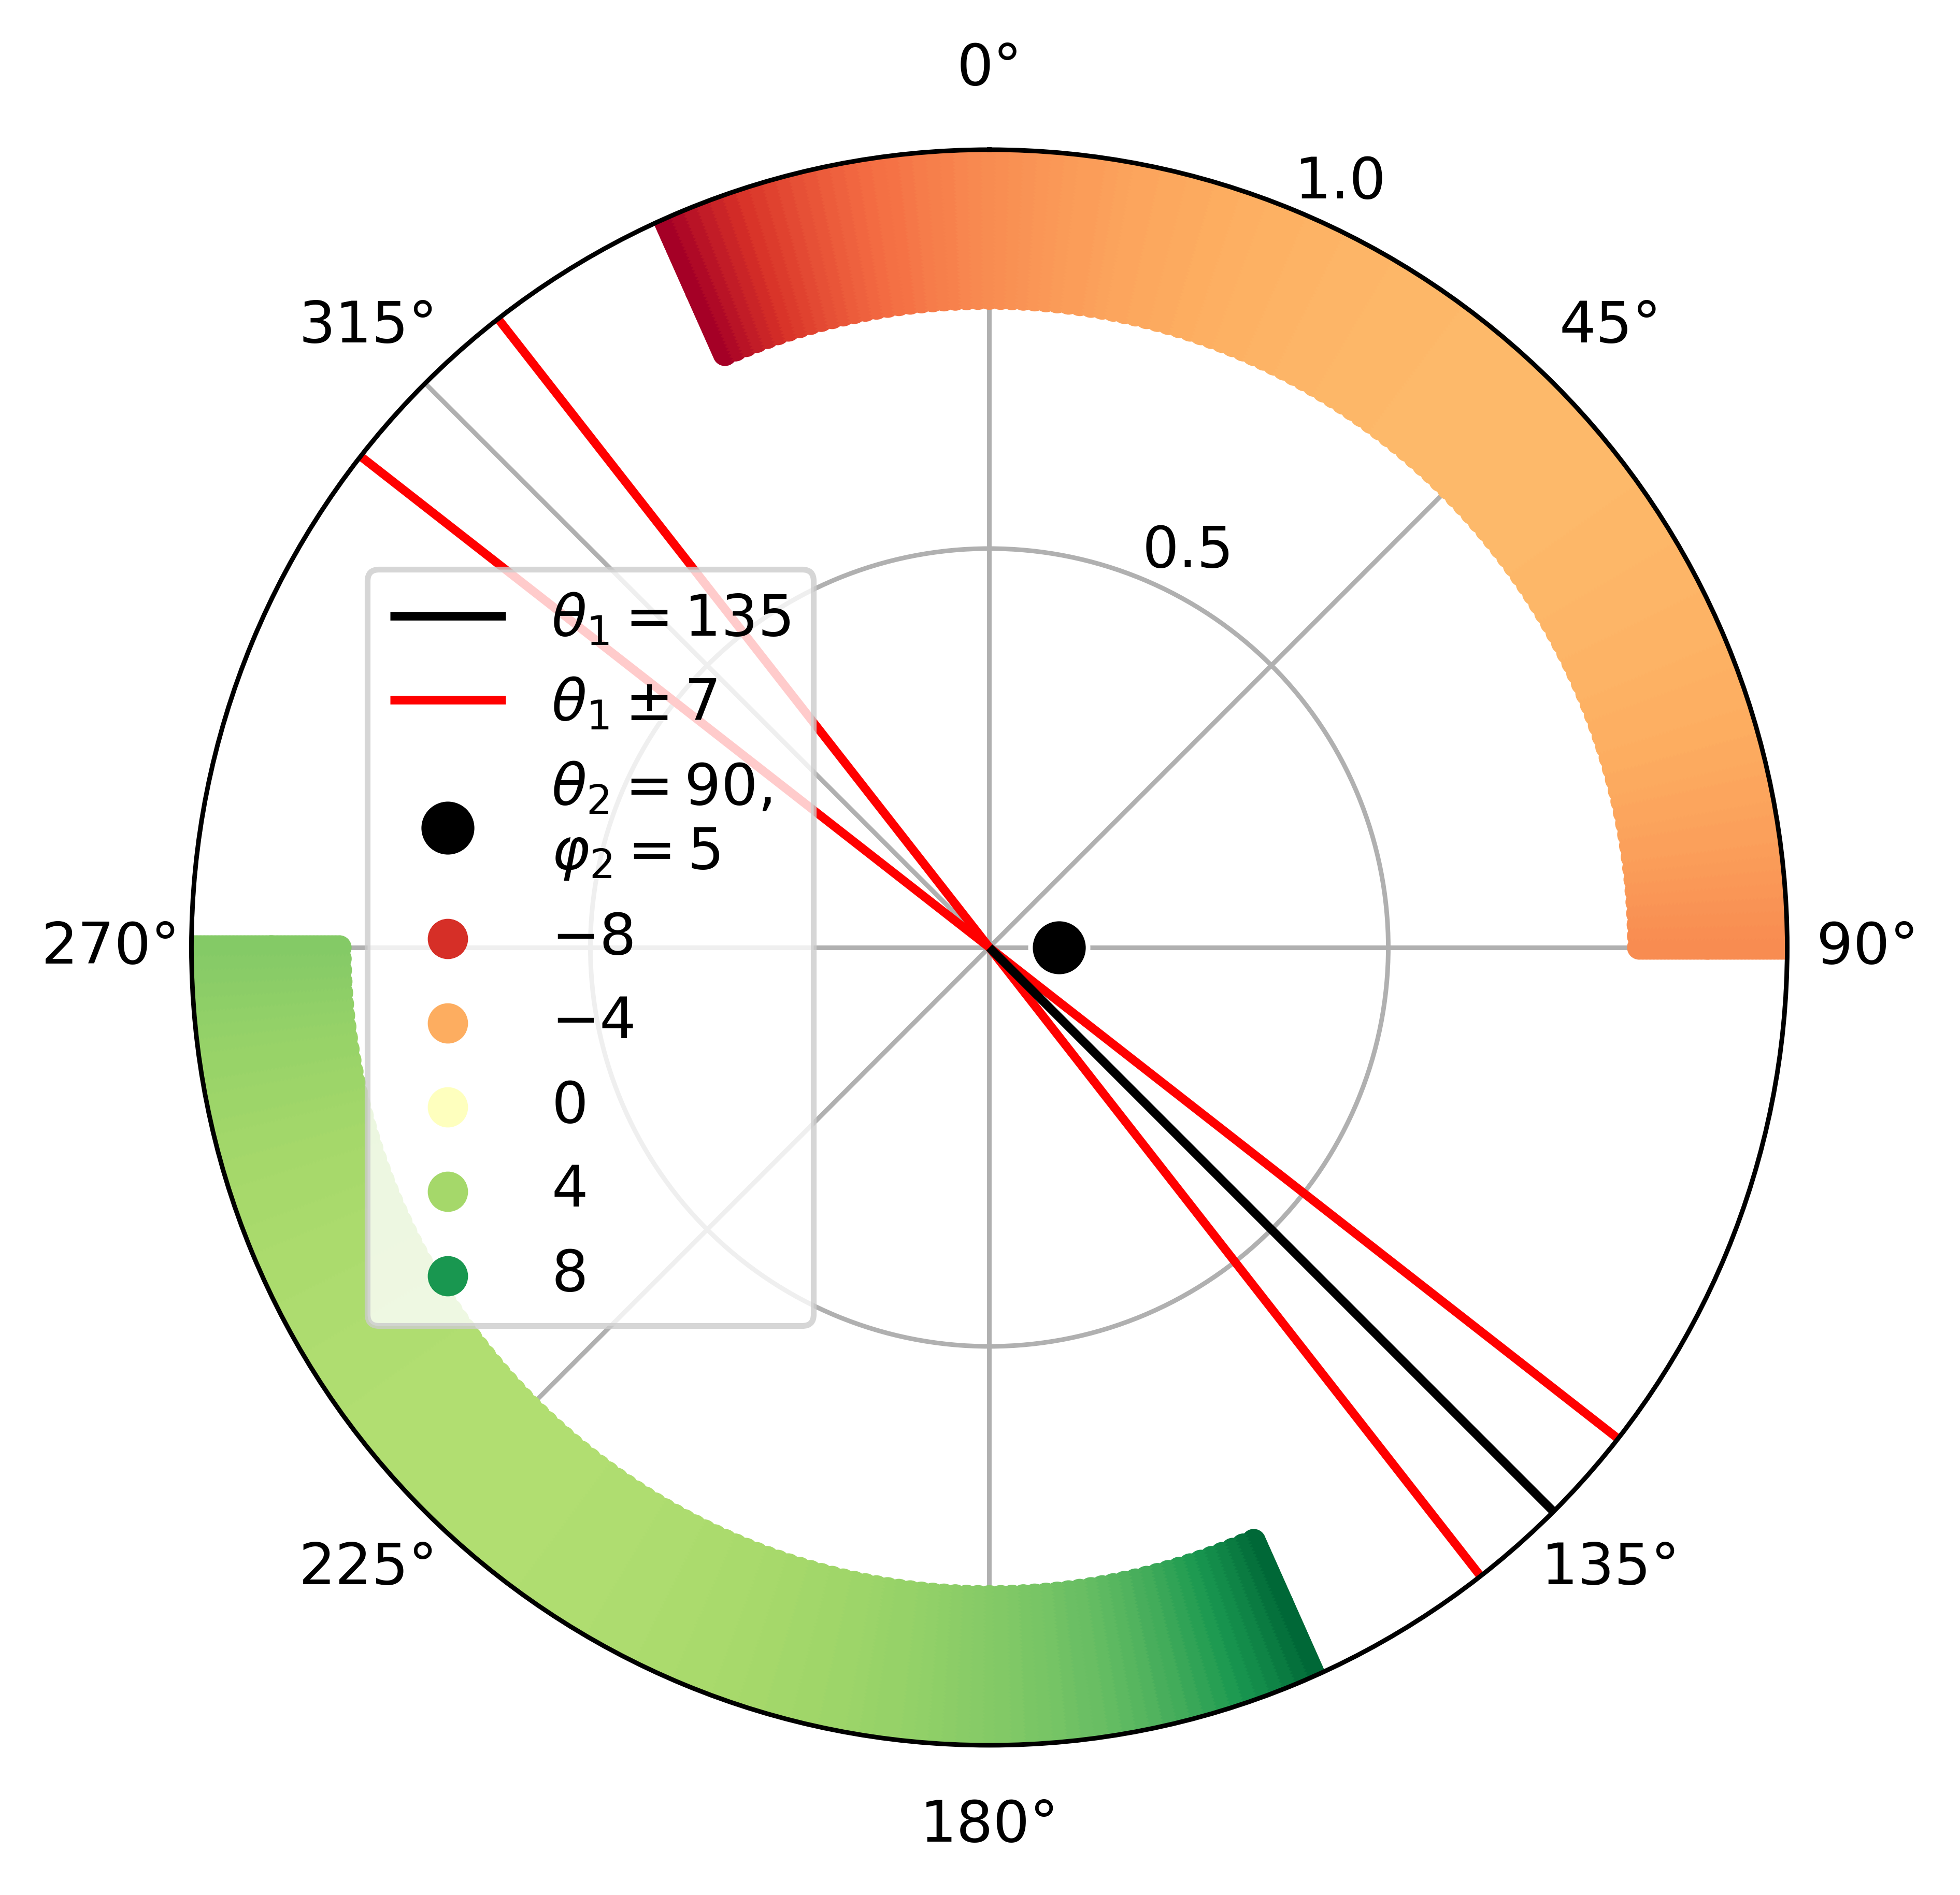

In [136]:
td.tilt_check(
    test_az1=135,
    test_az2=90,
    test_sl2=5,
    paleo_azimuth_uncertainty=0,
    minimum_offset=7,
    max_abs_tilt=10,
    legend_position=(.25, .5),
    plot_radius=1,
    # example_bearing=200,
    # full_tilt=False,
    plot_resolution=1,
)

# plt.title('No Max. Tilt') # if full_tilt
# plt.grid(axis='x') # if example 

# save_pdf(name='methods/tilt-check-blank') # just attitude
# save_pdf(name='methods/tilt-check-example') # with example tilt
# save_png(name='methods/tilt-check-example-rim')
# save_png(name='methods/tilt-check-rim')

# save_png('methods/tiltable-offset')

## Map Data

In [2]:
centers = pd.read_csv(f'{map_path}centers.csv').set_index('cID')
samples = pd.read_csv(f'{map_path}samples.csv').set_index('sID')

samples['DISC'] = samples.apply(
    lambda row: ((row['AZ2'] - row['AZ1'] + 180) % 360) - 180,
    axis=1
)

cIDs = centers.index.tolist()
sIDs = samples.index.tolist()

feature_sIDs = {
    'flow': samples.index[samples['FEATURE'] == 'flow'].tolist(),
    'channel': samples.index[samples['FEATURE'] == 'channel'].tolist(),
}

POP_A_sIDs = [198, 438, 439, 440, 441, 442, 443, 444, 445, 490, 491, 492, 493]
POP_B_sIDs = [193, 194, 195, 196, 197, 477, 478, 479, 480, 481, 544, 545, 548, 549]
POP_C_sIDs = [529, 530, 531, 532, 533, 537, 538, 539, 540, 541, 542, 543]
POP_ABC_sIDs = POP_A_sIDs + POP_B_sIDs + POP_C_sIDs
POP_E_sIDs = samples.index[samples['LON'] > -133.16554044].tolist()
POP_W_sIDs = samples.index[samples['LON'] < -133.16554044].tolist()


pop_all = td.Population(name='all', sIDs=sIDs)
pop_flow = td.Population(name='flow', sIDs=feature_sIDs['flow'])
pop_channel = td.Population(name='channel', sIDs=feature_sIDs['channel'])

pop_a = td.Population(name='A', sIDs=POP_A_sIDs)
pop_b = td.Population(name='B', sIDs=POP_B_sIDs)
pop_c = td.Population(name='C', sIDs=POP_C_sIDs)
pop_abc = td.Population(name='ABC', sIDs=POP_ABC_sIDs)

pop_e = td.Population(name='EAST', sIDs=POP_E_sIDs)
pop_w = td.Population(name='WEST', sIDs=POP_W_sIDs)

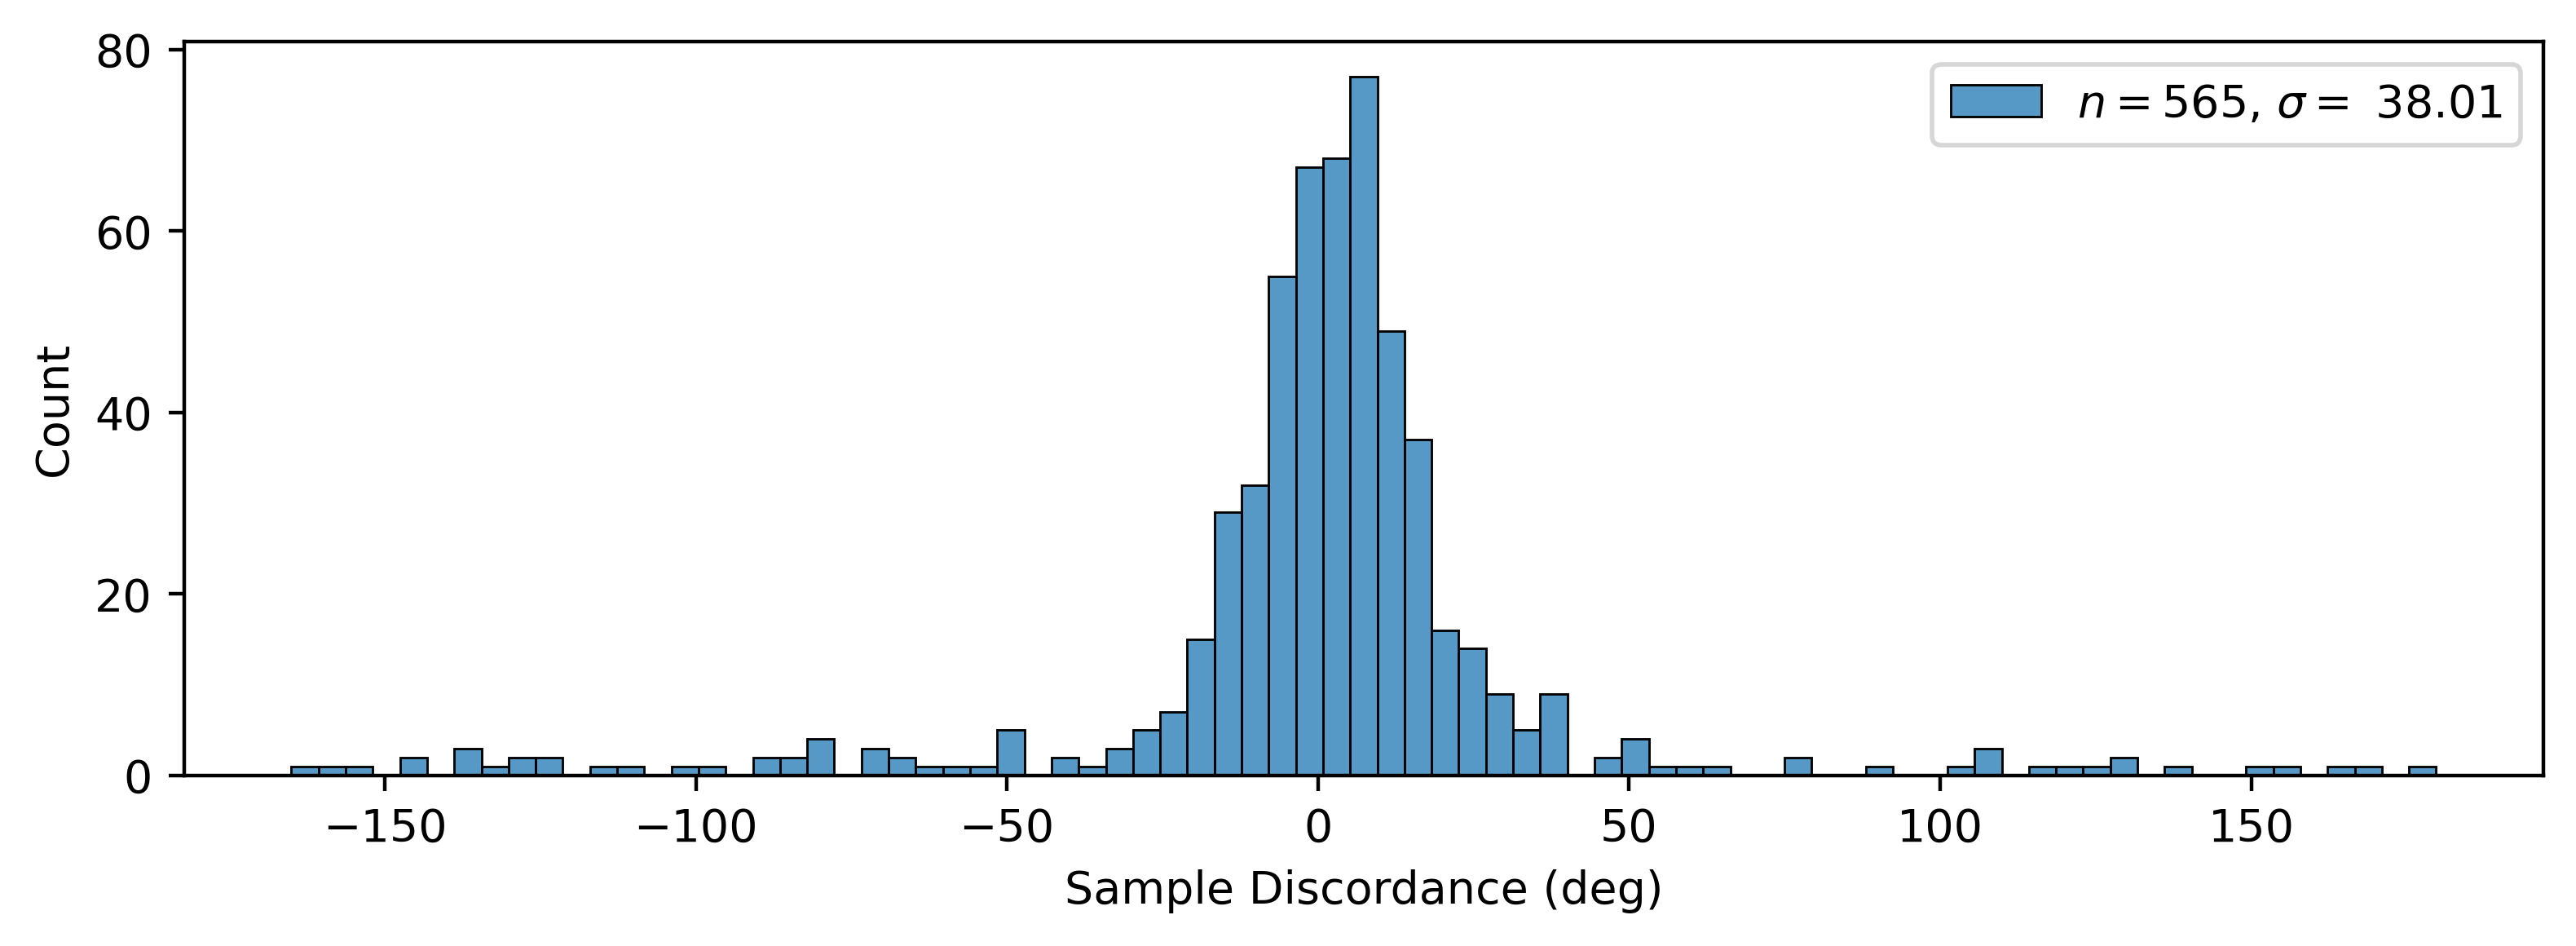

In [44]:
plt.figure(figsize=(8,3), dpi=400)
sns.histplot(samples['DISC'], label=f'$n=${len(samples)}, $\sigma =$ {round(np.std(samples["DISC"]), 2)}')
plt.legend()
plt.xlabel('Sample Discordance (deg)')
save_pdf('results/discordance')

Calculate tilt (etc.) for each sample, repeat for each center. Full dataset from which to pull subsets later.

In [3]:
paleo_azimuth_uncertainty = 0

centers_calc = {
    cID: td.make_center(cID, centers, samples, paleo_azimuth_uncertainty)
    for cID in cIDs
}

Define criteria and perform evaluation. This takes less than two minutes on my machine.

In [4]:
criteria = [
    td.Criterion(td.subset_sizes(7), pop_abc),
    td.Criterion(td.inflation_score(7), pop_abc),
    td.Criterion(td.subset_sizes(7), pop_all),
    td.Criterion(td.inflation_score(7), pop_all),
]

scores = {}
score_names = []

for cID, center in centers_calc.items():
    scores_for_this_center = []
    for crit in criteria:
        scores_for_this_criterion = td.evaluate_center(center, crit)
        for key, val in scores_for_this_criterion.items():
            scores_for_this_center.append(val)
            full_score_name = f'{crit.pop.name}_{key}'
            if full_score_name not in score_names:
                score_names.append(full_score_name)
    scores[cID] = scores_for_this_center

centers_eval = pd.DataFrame(scores).transpose().set_axis(score_names, axis=1)
centers_eval_no_infs = centers_eval.replace([np.inf, -np.inf], np.nan)

Write evaluation to disk.

In [6]:
centers_eval_no_infs.to_csv(
    f'{map_path}centers_eval.csv',
    index_label='cID'
)

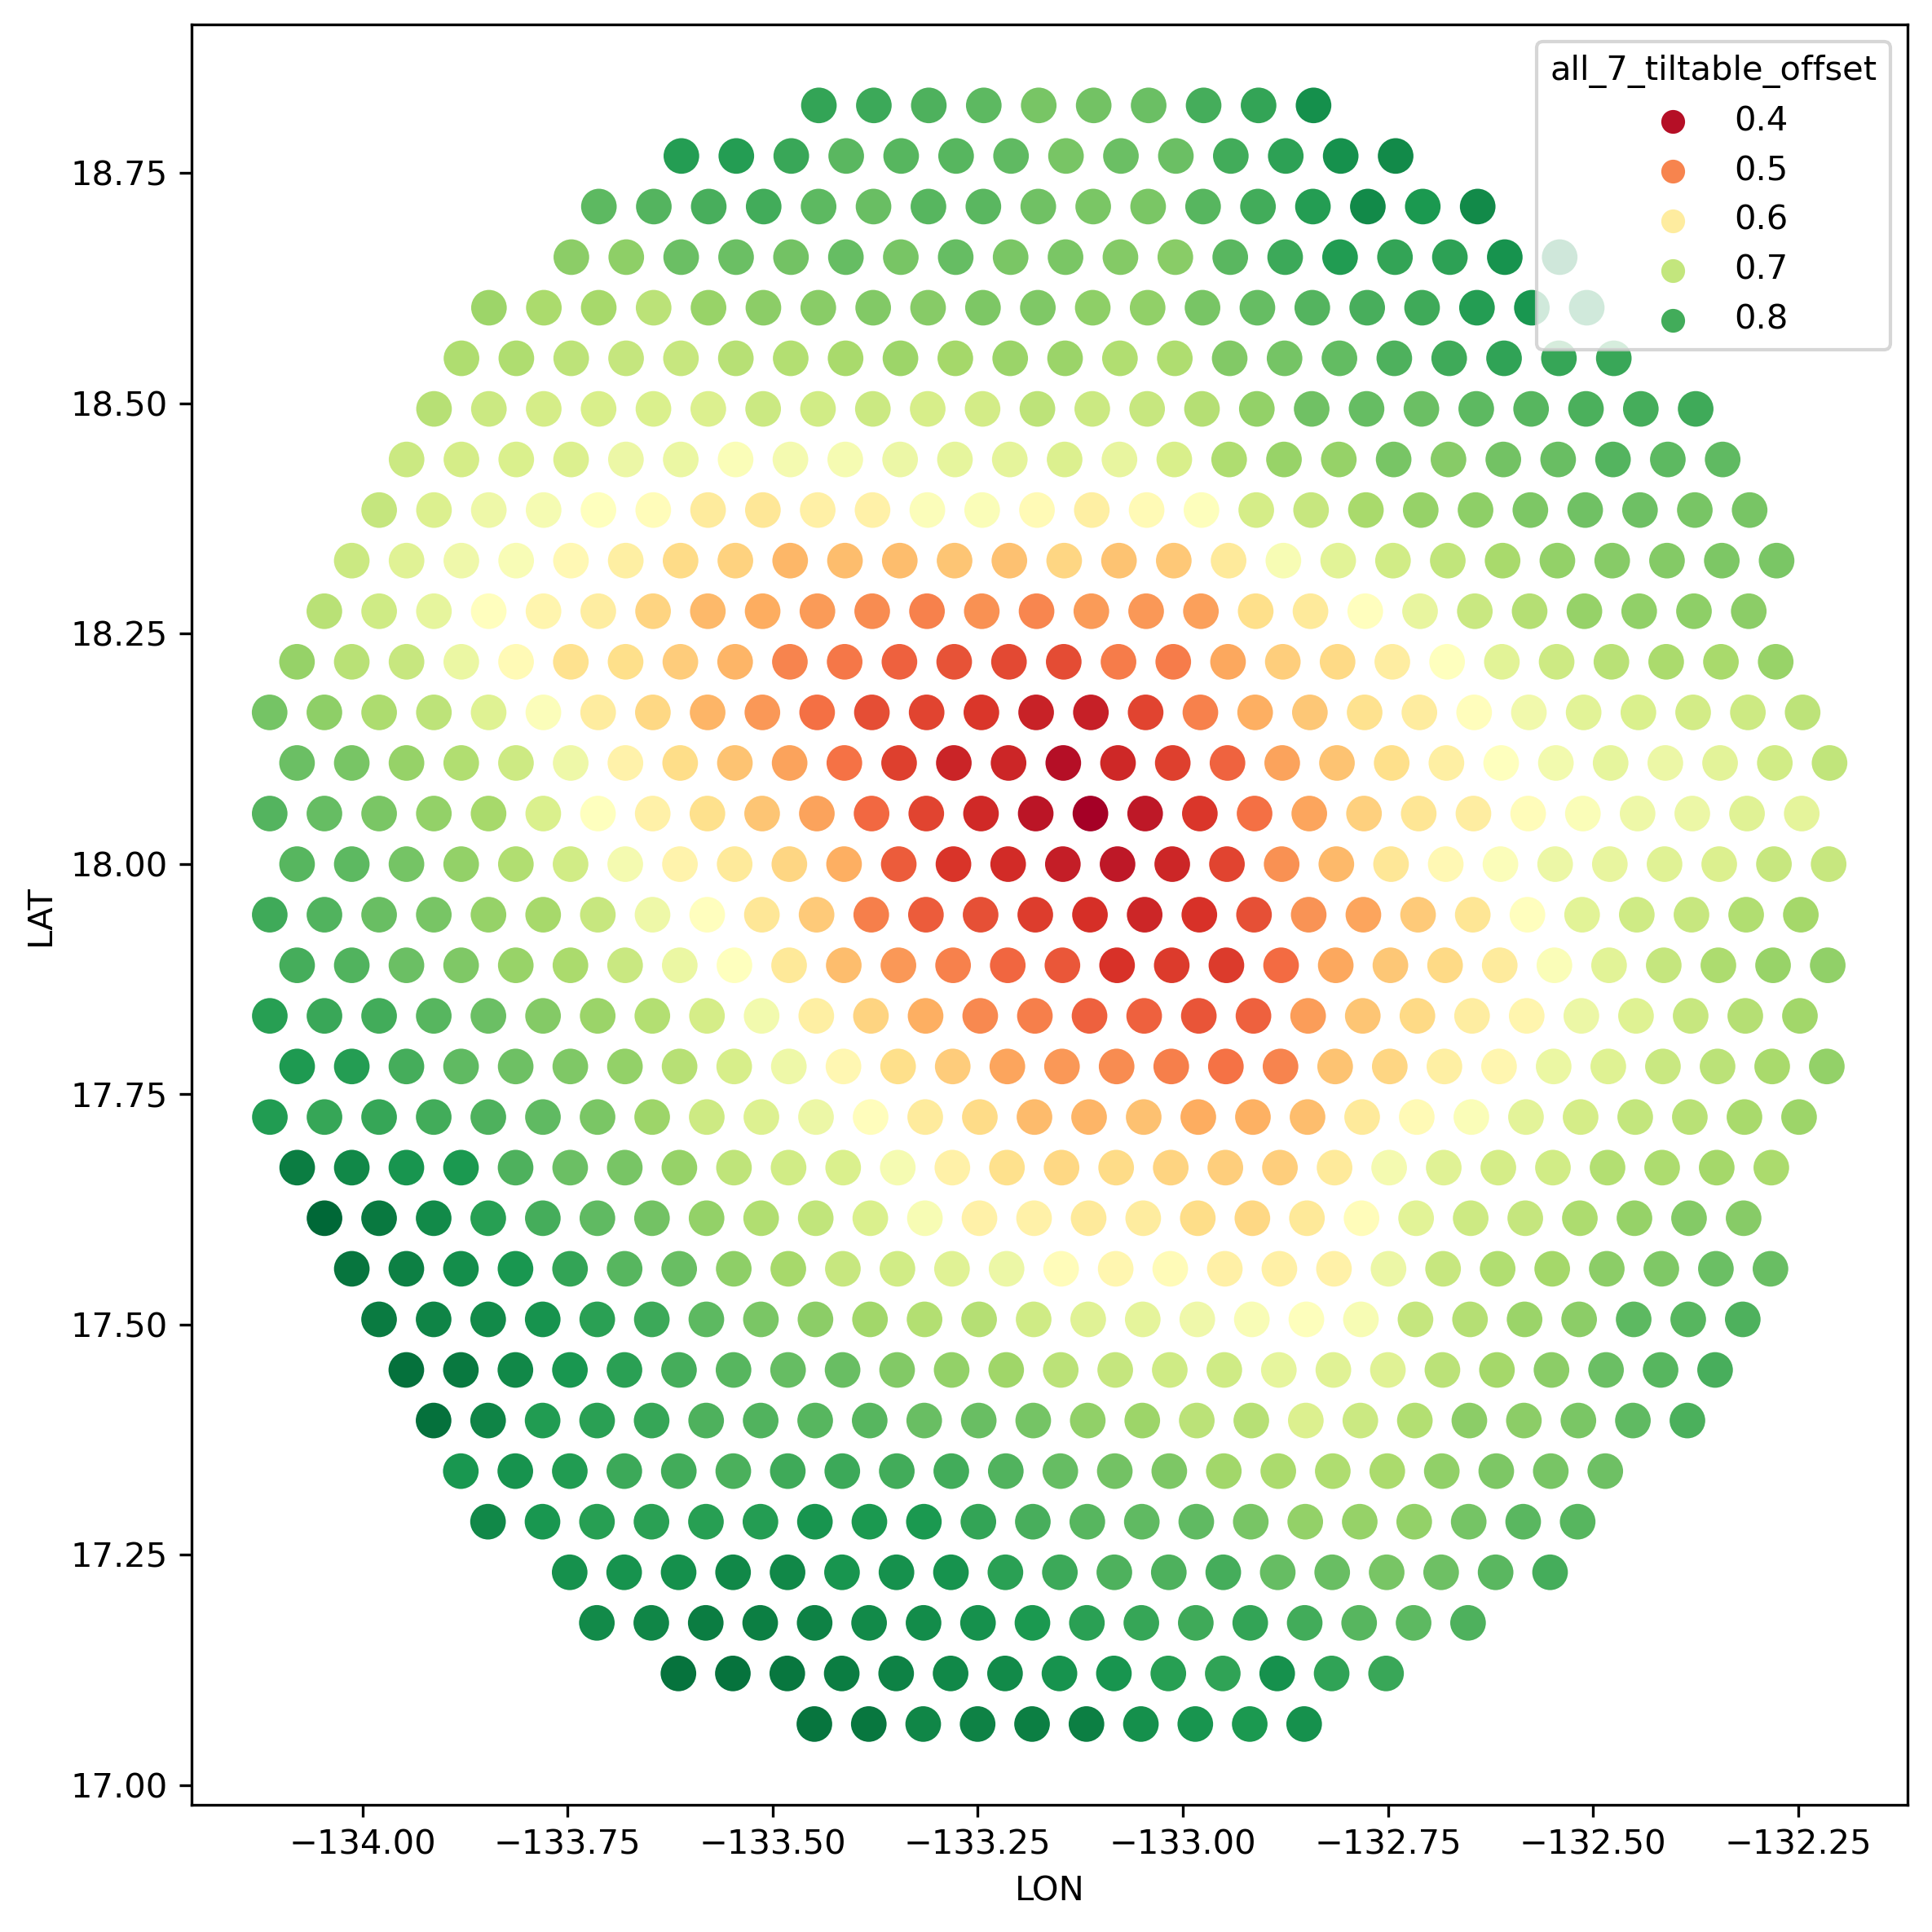

In [45]:
plt.figure(figsize=(8,8), dpi=300)

data = centers_eval_no_infs
sns.scatterplot(data=data, x=centers['LON'], y=centers['LAT'], hue=centers_eval_no_infs['all_7_tiltable_offset'], palette='RdYlGn', s=130)

save_pdf('results/full-tiltable-offset')

Text(0, 0.5, 'Tilt (deg)')

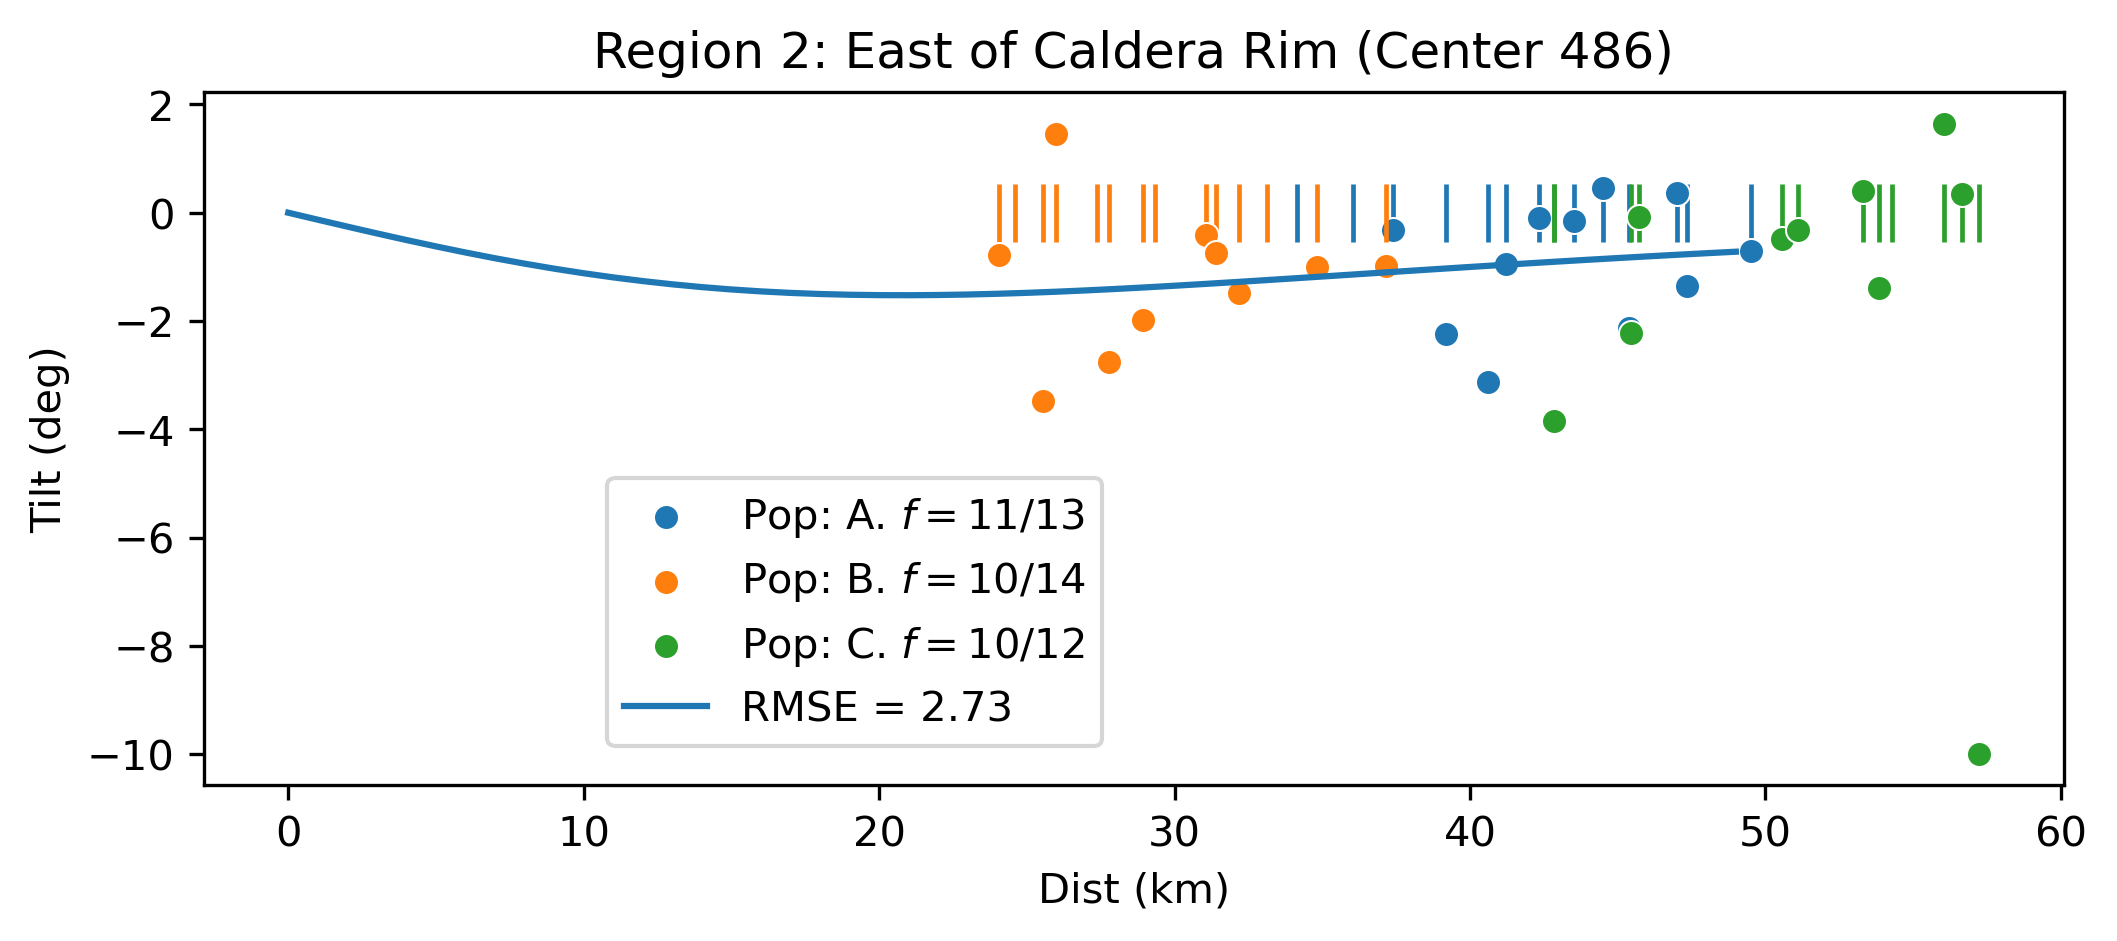

In [65]:
cID = 486

plt.figure(figsize=(8, 3), dpi=300)

alignment_threshold_degrees = 7
alignment_threshold = np.cos(np.radians(alignment_threshold_degrees))
centers_calc[cID].plot_tilt(
    [pop_a, pop_b, pop_c],
    max_alignment=alignment_threshold,
    min_alignment=-alignment_threshold,
)

eval = centers_eval_no_infs.loc[cID]
if eval['ABC_7_inflation']:
    epv_sign = 1
else:
    epv_sign = -1
fit_energy = 10**eval['ABC_7_log10_epv'] * epv_sign
fit_d = eval['ABC_7_depth_m']
interval_m = np.arange(0,50_000,1000)
fit_tilt = [td.mogi_tilt(dist,fit_energy, fit_d) for dist in interval_m]
interval_km = interval_m / 1000
sns.lineplot(x=interval_km,y=fit_tilt, label=f"RMSE = {round(eval['ABC_7_rmse'],2)}")

# plt.xlim(22.96, 22.97)
plt.legend(
    loc='center',
    bbox_to_anchor=(.35,.25)
    )
# plt.ylim(-20, None)

plt.title(f'Region 2: East of Caldera Rim (Center {cID})')
plt.xlabel('Dist (km)')
plt.ylabel('Tilt (deg)')

# save_pdf(f'results/{cID}-analytical')

## Model data

Define parameter combinations.

In [5]:
def params_from_disp_filename(name):
    name_split = name.split('_')[1:]
    params = {
        'depth' : int(name_split[1]),
        'radius' : int(name_split[3]),
        'aspect' : float(name_split[5]),
        'pmult' : name_split[7],
        'grav' : int(name_split[9]),
        'topo' : int(name_split[11].split('.')[0])
    }
    return params

# full_sweep = td.ParamSweep(
#     [params_from_disp_filename(name) for name in disp_names[:100]],
#     model_topo
# )

In [ ]:
oblate_deflation_params = {
    "depth": [8000, 9000, 10_000, 11_000, 12_000], # 25
    "radius": [25_000, 26_000, 27_000], # 5
    "aspect": [0.1, 0.15, 0.2, 0.25],
    "pmult": [-0.5, -0.75, -1, -1.25, -1.5],
    "grav": [False],
    "topo": [True],
}

oblate_deep_deflation_params = {
    "depth": [12_000, 14_000, 16_000], # 25
    "radius": [24_000, 26_000, 28_000, 30_000], # 5
    "aspect": [0.1, 0.15, 0.2, 0.25],
    "pmult": [-0.75, -1, -1.25, -1.5, -1.75],
    "grav": [False],
    "topo": [True],
}

wide_params = {
    "depth": [16_000, 18_000, 20_000, 22_000],
    "radius": [30_000, 32_000, 34_000, 36_000],
    "aspect": [0.1, 0.15, 0.2, 0.25],
    "pmult": [-1],
    "grav": [False],
    "topo": [True],
}

extra_wide_params = {
    "depth": [16_000, 18_000, 20_000, 22_000],
    "radius": [36_000, 40_000, 44_000, 48_000],
    "aspect": [0.05, 0.1, 0.15, 0.2],
    "pmult": [-1],
    "grav": [False],
    "topo": [True],
}

oblate_deflation_sweep = td.ParamSweep(
    # td.unpack_param_combinations(oblate_deflation_params)
    # + td.unpack_param_combinations(oblate_deep_deflation_params)
    td.unpack_param_combinations(wide_params)
    + td.unpack_param_combinations(extra_wide_params),
    model_topo
)

In [91]:
shallow_oblate_params = {
    "depth": [15_000],
    "radius": [20_000],
    "aspect": [.4],
    "pmult": [.6],
    "grav": [True, False],
    "topo": [True, False],
}

mogi_params = {
    "depth": [25_000],
    "radius": [5_000],
    "aspect": [1],
    "pmult": [1],
    "grav": [False],
    "topo": [False],
}

coarse_params_shallow = {
    "depth": [4_000, 8_000, 12_000],
    "radius": [5_000, 10_000],
    "aspect": [0.2, 0.5, 0.7],
    "pmult": [-1, -0.5, 0.5, 1],
    "grav": [False],
    "topo": [True],
}

coarse_params_deep = {
    "depth": [16_000, 20_000, 24_000], # 25
    "radius": [20_000, 25_000, 30_000], # 5
    "aspect": [0.2, 0.3, 0.5],
    "pmult": [-1, 1, 2],
    "grav": [False],
    "topo": [True],
}

oblate_inflation_params = {
    "depth": [8000, 9000, 10_000, 11_000, 12_000],
    "radius": [10_000, 26_000, 27_000],
    "aspect": [0.1, 0.15, 0.2, 0.25],
    "pmult": [-0.5, -0.75, -1, -1.25, -1.5],
    "grav": [False],
    "topo": [True],
}

In [92]:
mogi_test = td.ParamSweep(
    td.unpack_param_combinations(mogi_params),
    model_topo
)
mogi_shallow_oblate_test = td.ParamSweep(
    td.unpack_param_combinations(shallow_oblate_params),
    model_topo
)

shallow_coarse_sweep = td.ParamSweep(
    td.unpack_param_combinations(coarse_params_shallow),
    model_topo
)

In [4]:
def plot_section():
    top_surface_km = np.concatenate((model_topo, [[2_000_000], [0]]),1) / 1000
    sns.lineplot(x=top_surface_km[0], y=top_surface_km[1], c='black')
    sns.lineplot(x=[0, 2000], y=[-600, -600], c='black')
    plt.vlines(x=[0,2_000], ymin=-600, ymax=[top_surface_km[1,0], 0], colors=['black'])

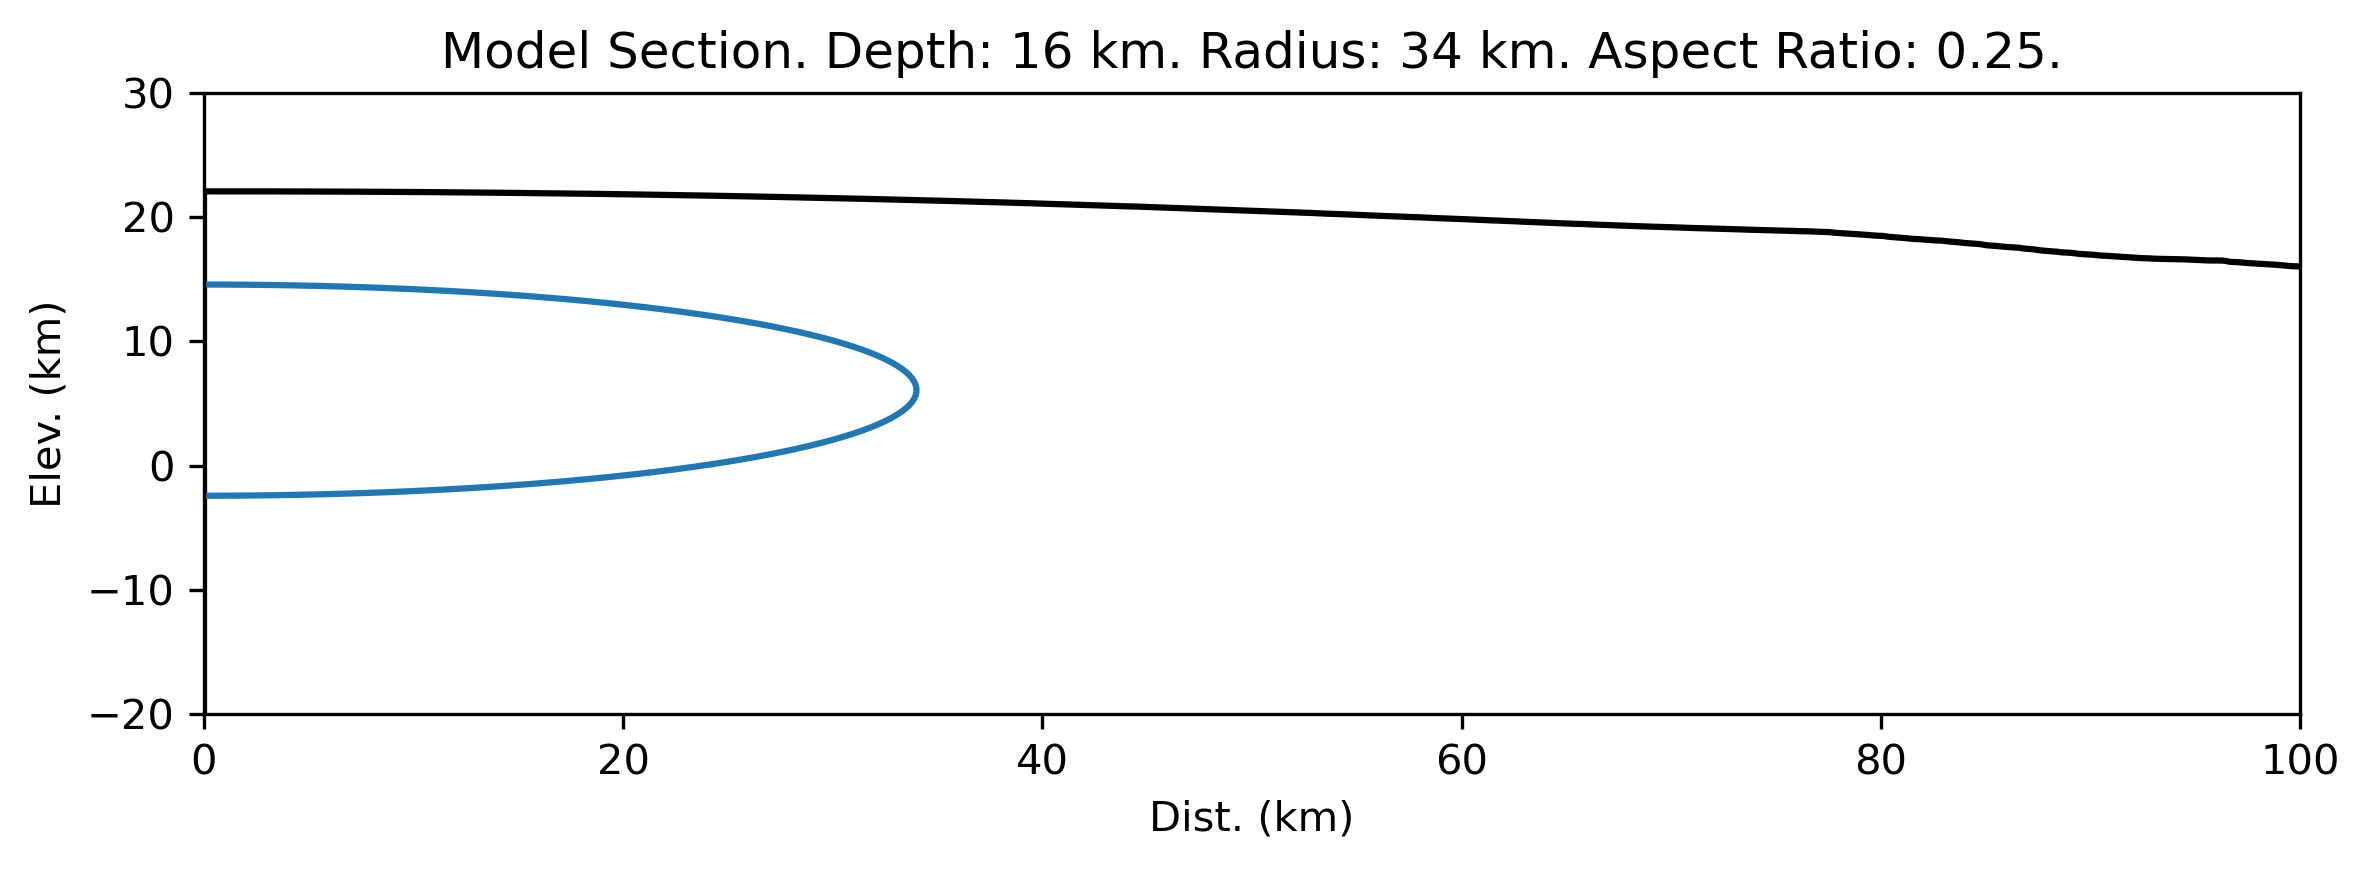

In [120]:
plt.figure(figsize=(8,3), dpi=300)
plot_section()
model = oblate_deflation_sweep.models[11]
model.plot_section(max_elev_km = max(model_topo[1]) / 1000, label='')
# plt.legend()
plt.title('Model Section. Depth: 16 km. Radius: 34 km. Aspect Ratio: 0.25.')

plt.ylabel('Elev. (km)')
plt.xlabel('Dist. (km)')

plt.xlim(0, 100)
plt.ylim(-20, 30)
# plt.hlines(y=(max(model_topo[1])/1000 - 16), xmin=0, xmax=34, color='black')

# save_pdf('methods/model-section-zoom')

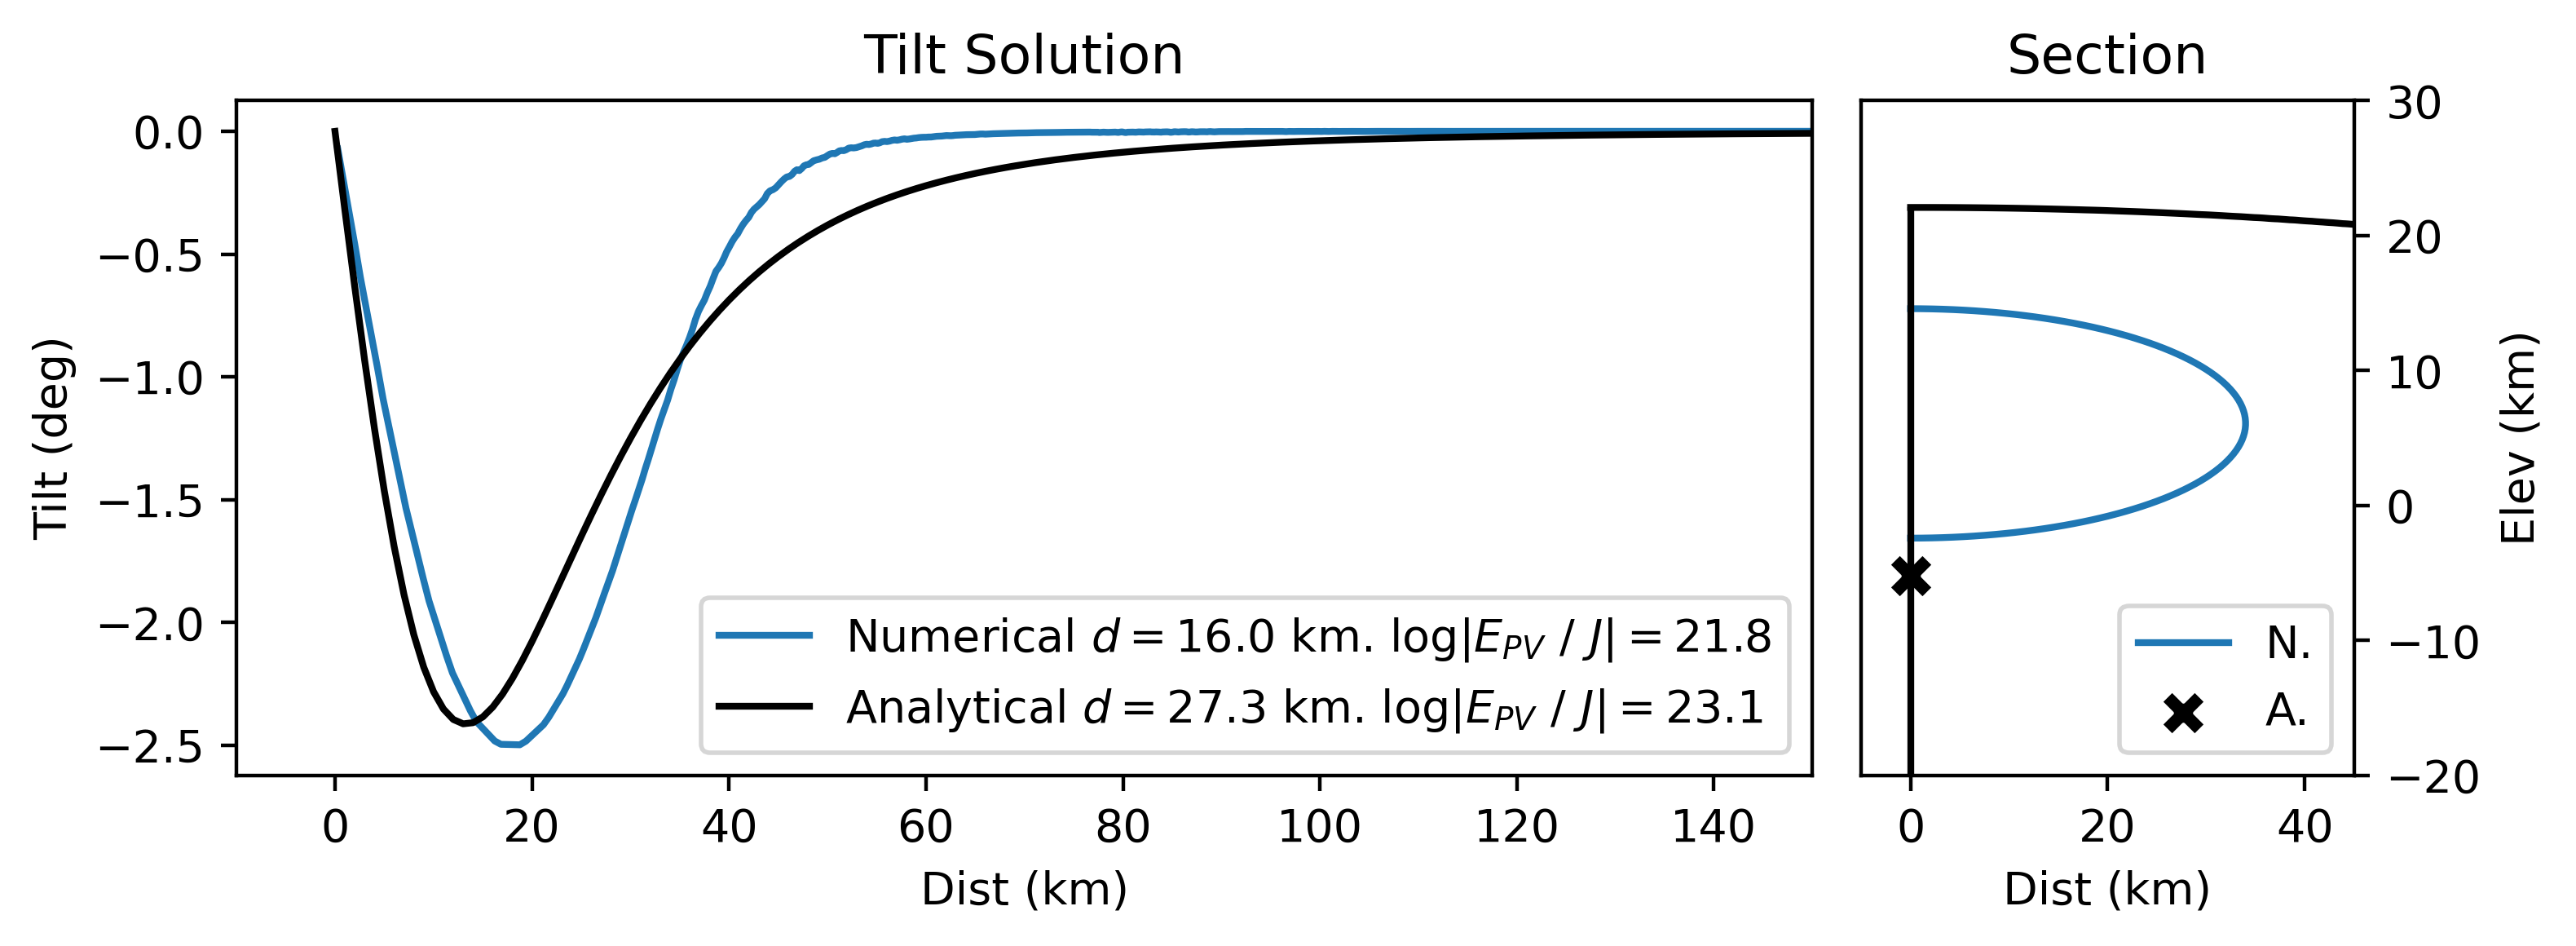

In [100]:
fig = plt.figure(figsize=(8,3),dpi=400)

tilt_ax = fig.add_subplot(1,4,(1,3))
model = oblate_deflation_sweep.models[11]

model.plot_numerical_tilt(label=f'Numerical $d = {round(model.params["depth"]/1000,1)}$ km. '+ '$\log|E_{PV}\ /\ J| = $' + f'{round(np.log10(np.abs(model.epv)),1)}')

plt.xlim(-10,150)
plt.xlabel('Dist (km)')
plt.ylabel('Tilt (deg)')
plt.title('Tilt Solution')

fit = td.fit_mogi_function(df=model.data)
params, _ = fit
epv_J, depth_m = params

td.plot_mogi_tilt(epv_J, depth_m, dist_m_interval=(1, 1_000_000), label=f'Analytical $d = {round(depth_m/1000,1)}$ km. ' + '$\log|E_{PV}\ /\ J| = $' + f'{round(np.log10(np.abs(epv_J)),1)}')

section_ax = fig.add_subplot(1,4,4)
model.plot_section(max_elev_km = max(model_topo[1]) / 1000, label='N.')

plt.xlim(-5, 45)
plt.ylim(-20, 30)
sns.scatterplot(x=[0], y=[(max(model_topo[1]) - depth_m) / 1000], c='black', marker='X', s=100, label='A.')

section_ax.yaxis.tick_right()
section_ax.yaxis.set_label_position("right")
plt.ylabel('Elev (km)')
plt.xlabel('Dist (km)')

plot_section()
plt.legend(loc='lower right')
plt.title('Section')

# save_pdf('methods/mogi-test-shallow-oblate')

model.params['depth']=20000
model.params['radius']=30000
model.params['aspect']=0.5
model.params['pmult']=-1


Text(0.5, 1.0, 'Center 486')

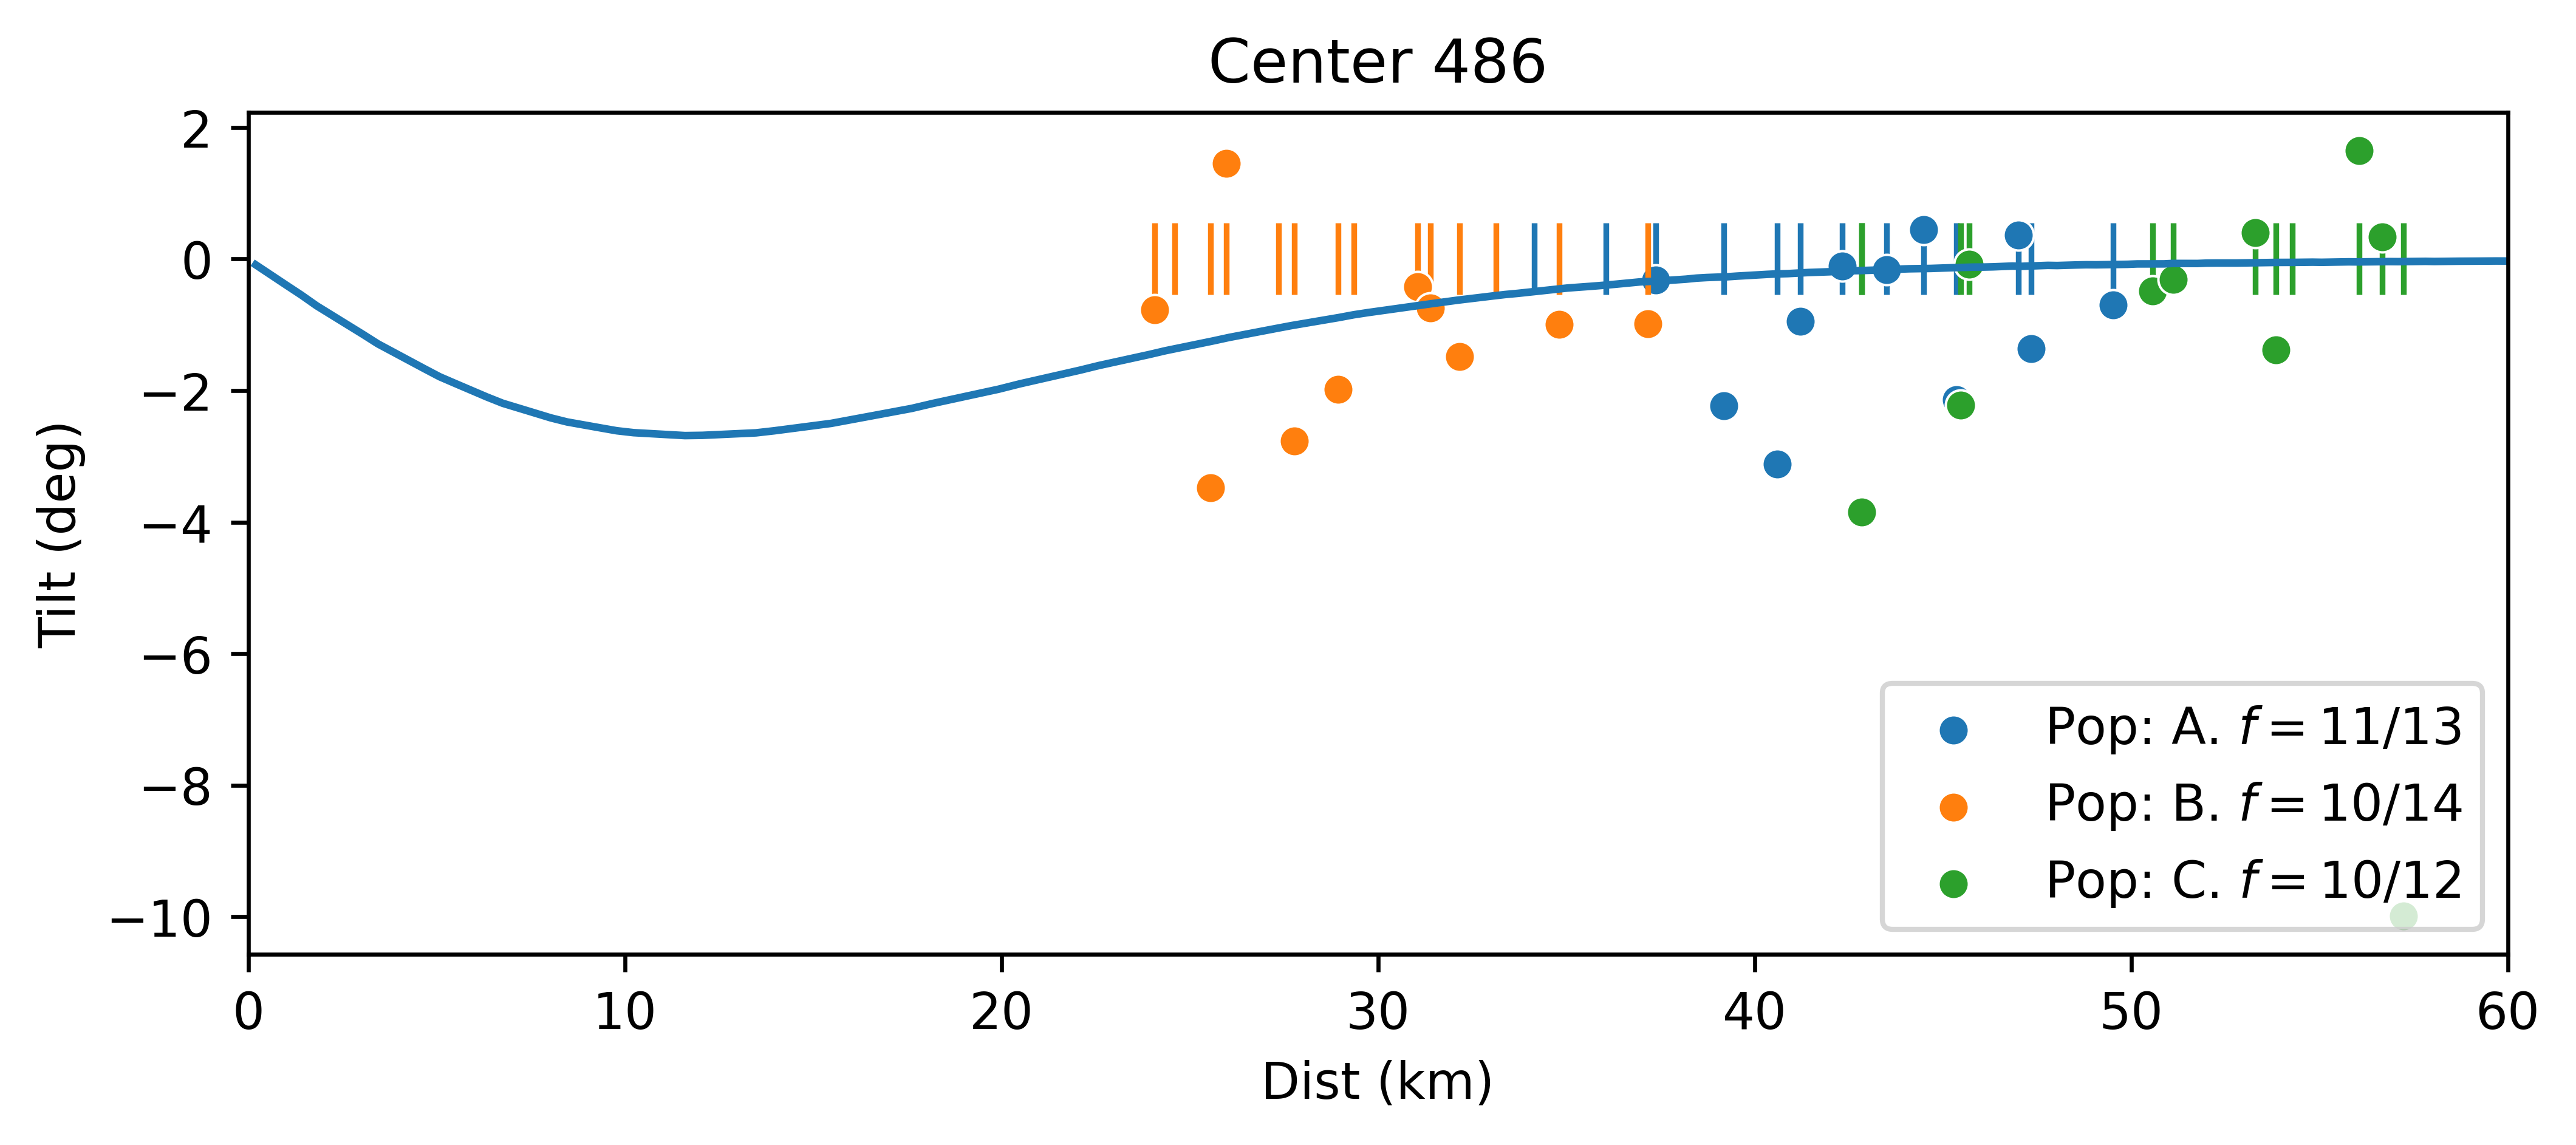

In [10]:
cID = 486

full_coarse_sweep.sort_models_by_rmse(
    center=centers_calc[cID],
    sIDs=pop_abc.sIDs
    )

plt.figure(figsize=(8,3), dpi=600)

for model in full_coarse_sweep.models[:1]:
    print(f"{model.params['depth']=}")
    print(f"{model.params['radius']=}")
    print(f"{model.params['aspect']=}")
    print(f"{model.params['pmult']=}")
    model.plot_numerical_tilt()

plt.ylabel('Tilt (deg)')
plt.xlabel('Dist (km)')
plt.xlim(0, 50)


centers_calc[cID].plot_tilt(
    [pop_a, pop_b, pop_c]
)

plt.legend(loc='lower right')
plt.xlim(0,60)

plt.title(f'Center {cID}')

In [96]:
oblate_deflation_params = {
    "depth": [8000, 9000, 10_000, 11_000, 12_000], # 25
    "radius": [25_000, 26_000, 27_000], # 5
    "aspect": [0.1, 0.15, 0.2, 0.25],
    "pmult": [-0.5, -0.75, -1, -1.25, -1.5],
    "grav": [False],
    "topo": [True],
}

oblate_deep_deflation_params = {
    "depth": [12_000, 14_000, 16_000], # 25
    "radius": [24_000, 26_000, 28_000, 30_000], # 5
    "aspect": [0.1, 0.15, 0.2, 0.25],
    "pmult": [-0.75, -1, -1.25, -1.5, -1.75],
    "grav": [False],
    "topo": [True],
}

wide_params = {
    "depth": [16_000, 18_000, 20_000, 22_000],
    "radius": [30_000, 32_000, 34_000, 36_000],
    "aspect": [0.1, 0.15, 0.2, 0.25],
    "pmult": [-1],
    "grav": [False],
    "topo": [True],
}

extra_wide_params = {
    "depth": [16_000, 18_000, 20_000, 22_000],
    "radius": [36_000, 40_000, 44_000, 48_000],
    "aspect": [0.05, 0.1, 0.15, 0.2],
    "pmult": [-1],
    "grav": [False],
    "topo": [True],
}

oblate_deflation_sweep = td.ParamSweep(
    # td.unpack_param_combinations(oblate_deflation_params)
    # + td.unpack_param_combinations(oblate_deep_deflation_params)
    td.unpack_param_combinations(wide_params)
    + td.unpack_param_combinations(extra_wide_params),
    model_topo
)

In [49]:
deep_fine_tune_params = {
    "depth": [20_000, 21_000, 22_000, 23_000],
    "radius": [44_000,45_000,46_000,47_000,48_000,49_000,50_000],
    "aspect": [0.04, 0.06, 0.08, 0.1, 0.12],
    "pmult": [-1],
    "grav": [False],
    "topo": [True],
}

deep_fine_tune_sweep = td.ParamSweep(
    td.unpack_param_combinations(deep_fine_tune_params),
    model_topo
)

In [50]:
shallow_extra_wide_params = {
    "depth": [10_000, 12_000, 14_000, 16_000, 18_000],
    "radius": [35_000, 40_000, 45_000],
    "aspect": [0.04, 0.06, 0.08, 0.1, 0.12],
    "pmult": [-.2, -.4, -.6, -.8],
    "grav": [False],
    "topo": [True],
}

shallow_extra_wide_sweep = td.ParamSweep(
    td.unpack_param_combinations(shallow_extra_wide_params)
    # + td.unpack_param_combinations(deep_fine_tune_params)
    , model_topo
)

In [51]:
shallow_extra_wide_fine_params = {
    "depth": [10_000, 12_000, 14_000, 16_000, 18_000],
    "radius": [35_000, 40_000, 45_000],
    "aspect": [0.04, 0.06, 0.08, 0.1, 0.12],
    "pmult": [-.2, -.4, -.6, -.8],
    "grav": [False],
    "topo": [True],
}

shallow_extra_wide_fine_sweep = td.ParamSweep(
    td.unpack_param_combinations(shallow_extra_wide_fine_params)
    # + td.unpack_param_combinations(deep_fine_tune_params)
    , model_topo
)

In [52]:
very_shallow_mid_width_fine_params = {
    "depth": [6000, 7000, 8000, 9000, 10_000],
    "radius": [25_000, 30_000, 35_000],
    "aspect": [0.04, 0.06, 0.08, 0.1, 0.12],
    "pmult": [-.2, -.4, -.6, -.8],
    "grav": [False],
    "topo": [True],
}

very_shallow_mid_width_sweep = td.ParamSweep(
    td.unpack_param_combinations(very_shallow_mid_width_fine_params)
    , model_topo
)

In [53]:
len(very_shallow_mid_width_sweep.models)

300

In [ ]:
very_shallow_mid_width_sweep.sort_models_by_rmse(
    center=centers_calc[cID],
    sIDs=pop_abc.sIDs
    )

shallow_extra_wide_sweep.sort_models_by_rmse(
    center=centers_calc[cID],
    sIDs=pop_abc.sIDs
    )

deep_fine_tune_sweep.sort_models_by_rmse(
    center=centers_calc[cID],
    sIDs=pop_abc.sIDs
    )

NumericalModel(params={'depth': 10000, 'radius': 35000, 'aspect': 0.04, 'pmult': -0.6, 'grav': False, 'topo': True}, rmse=2.2639575416250373)
NumericalModel(params={'depth': 18000, 'radius': 45000, 'aspect': 0.04, 'pmult': -0.8, 'grav': False, 'topo': True}, rmse=2.1289824755473172)
NumericalModel(params={'depth': 23000, 'radius': 46000, 'aspect': 0.04, 'pmult': -1, 'grav': False, 'topo': True}, rmse=2.108274859659408)


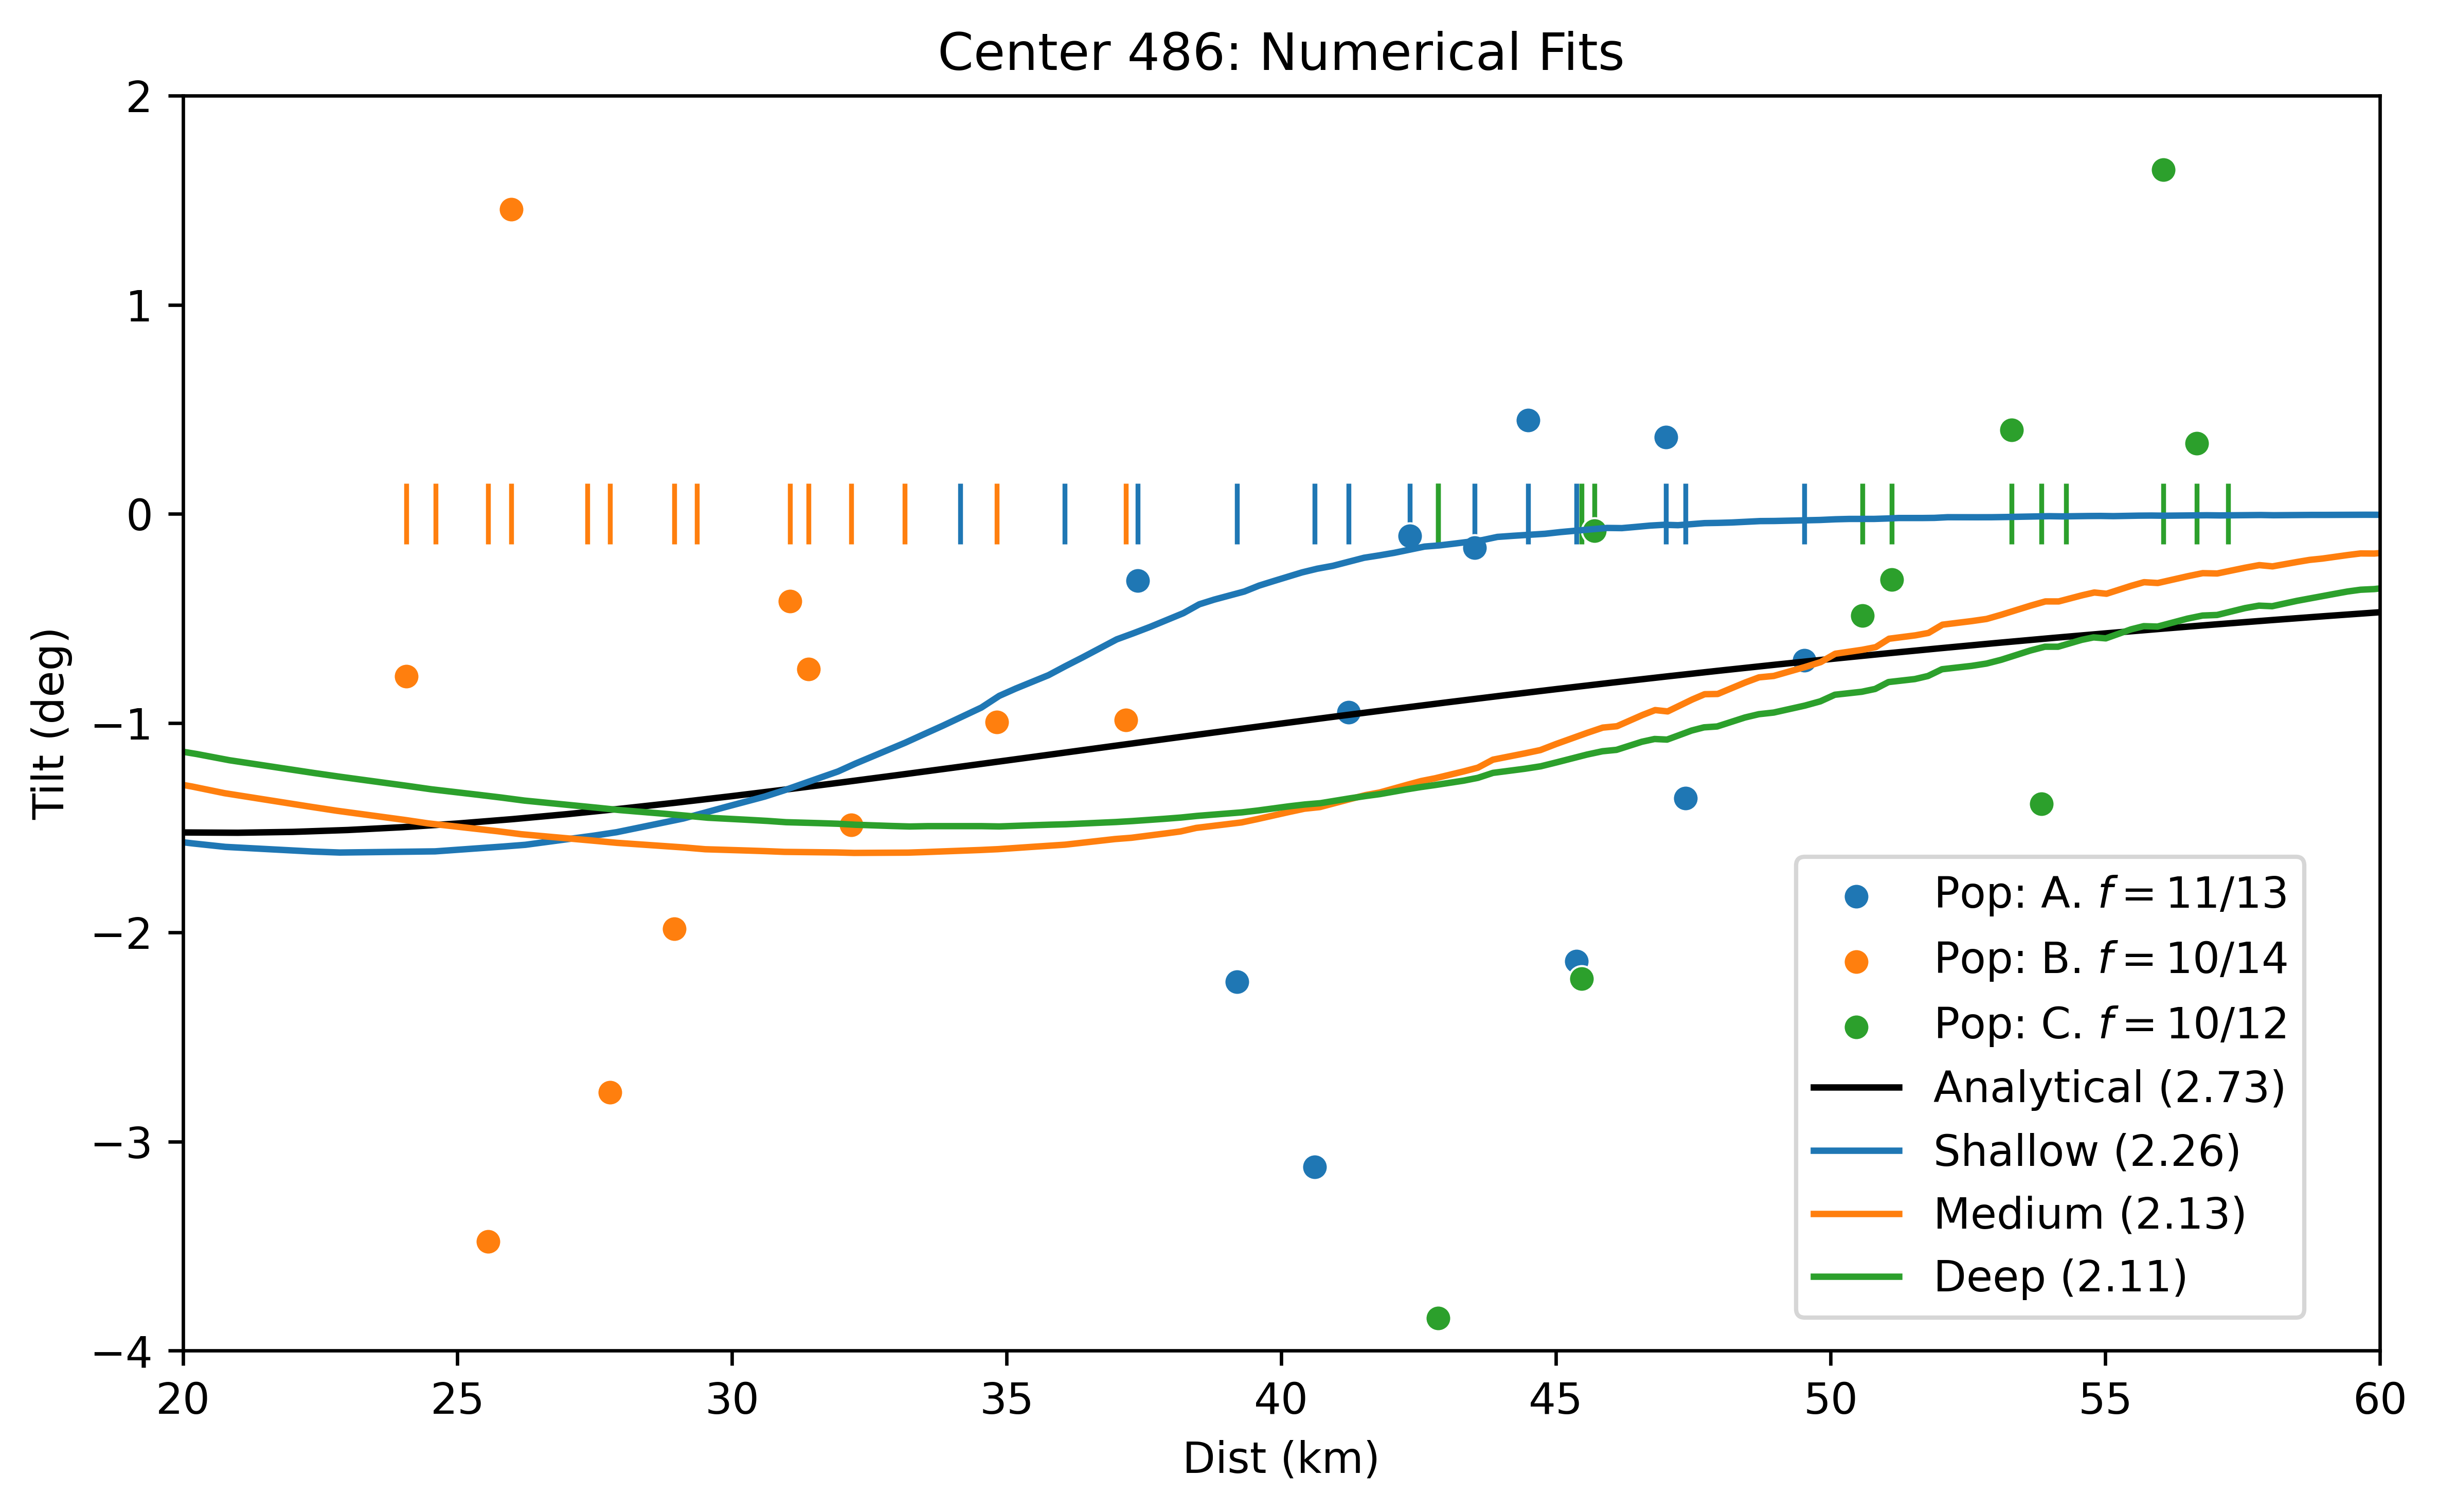

In [59]:
cID = 486

plt.figure(figsize=(8,5), dpi=600)

eval = centers_eval_no_infs.loc[cID]

fit_energy = 10**eval['ABC_7_log10_epv']
if not eval['ABC_7_inflation']:
    fit_energy *= -1
fit_d = eval['ABC_7_depth_m']

interval_m = np.arange(15000,70_000,1000)
fit_tilt = [td.mogi_tilt(dist,fit_energy, fit_d) for dist in interval_m]
interval_km = interval_m / 1000

centers_calc[cID].plot_tilt(
    [pop_a, pop_b, pop_c]
)

plt.xlim(20,60)
plt.ylim(-4,2)

sns.lineplot(x=interval_km,y=fit_tilt, label=f"Analytical ({round(eval['ABC_7_rmse'],2)})", color='black')

for model in very_shallow_mid_width_sweep.models[:1]:
    print(model)
    model.plot_numerical_tilt(label=f'Shallow ({round(model.rmse,2)})')
    
for model in shallow_extra_wide_sweep.models[:1]:
    print(model)
    model.plot_numerical_tilt(label=f'Medium ({round(model.rmse,2)})')
    
for model in deep_fine_tune_sweep.models[:1]:
    print(model)
    model.plot_numerical_tilt(label=f'Deep ({round(model.rmse,2)})')

plt.ylabel('Tilt (deg)')
plt.xlabel('Dist (km)')

plt.legend(loc='center', bbox_to_anchor=(.85,.21))

plt.title(f'Center {cID}: Numerical Fits')

save_pdf(f'results/{cID}-numerical-fits')

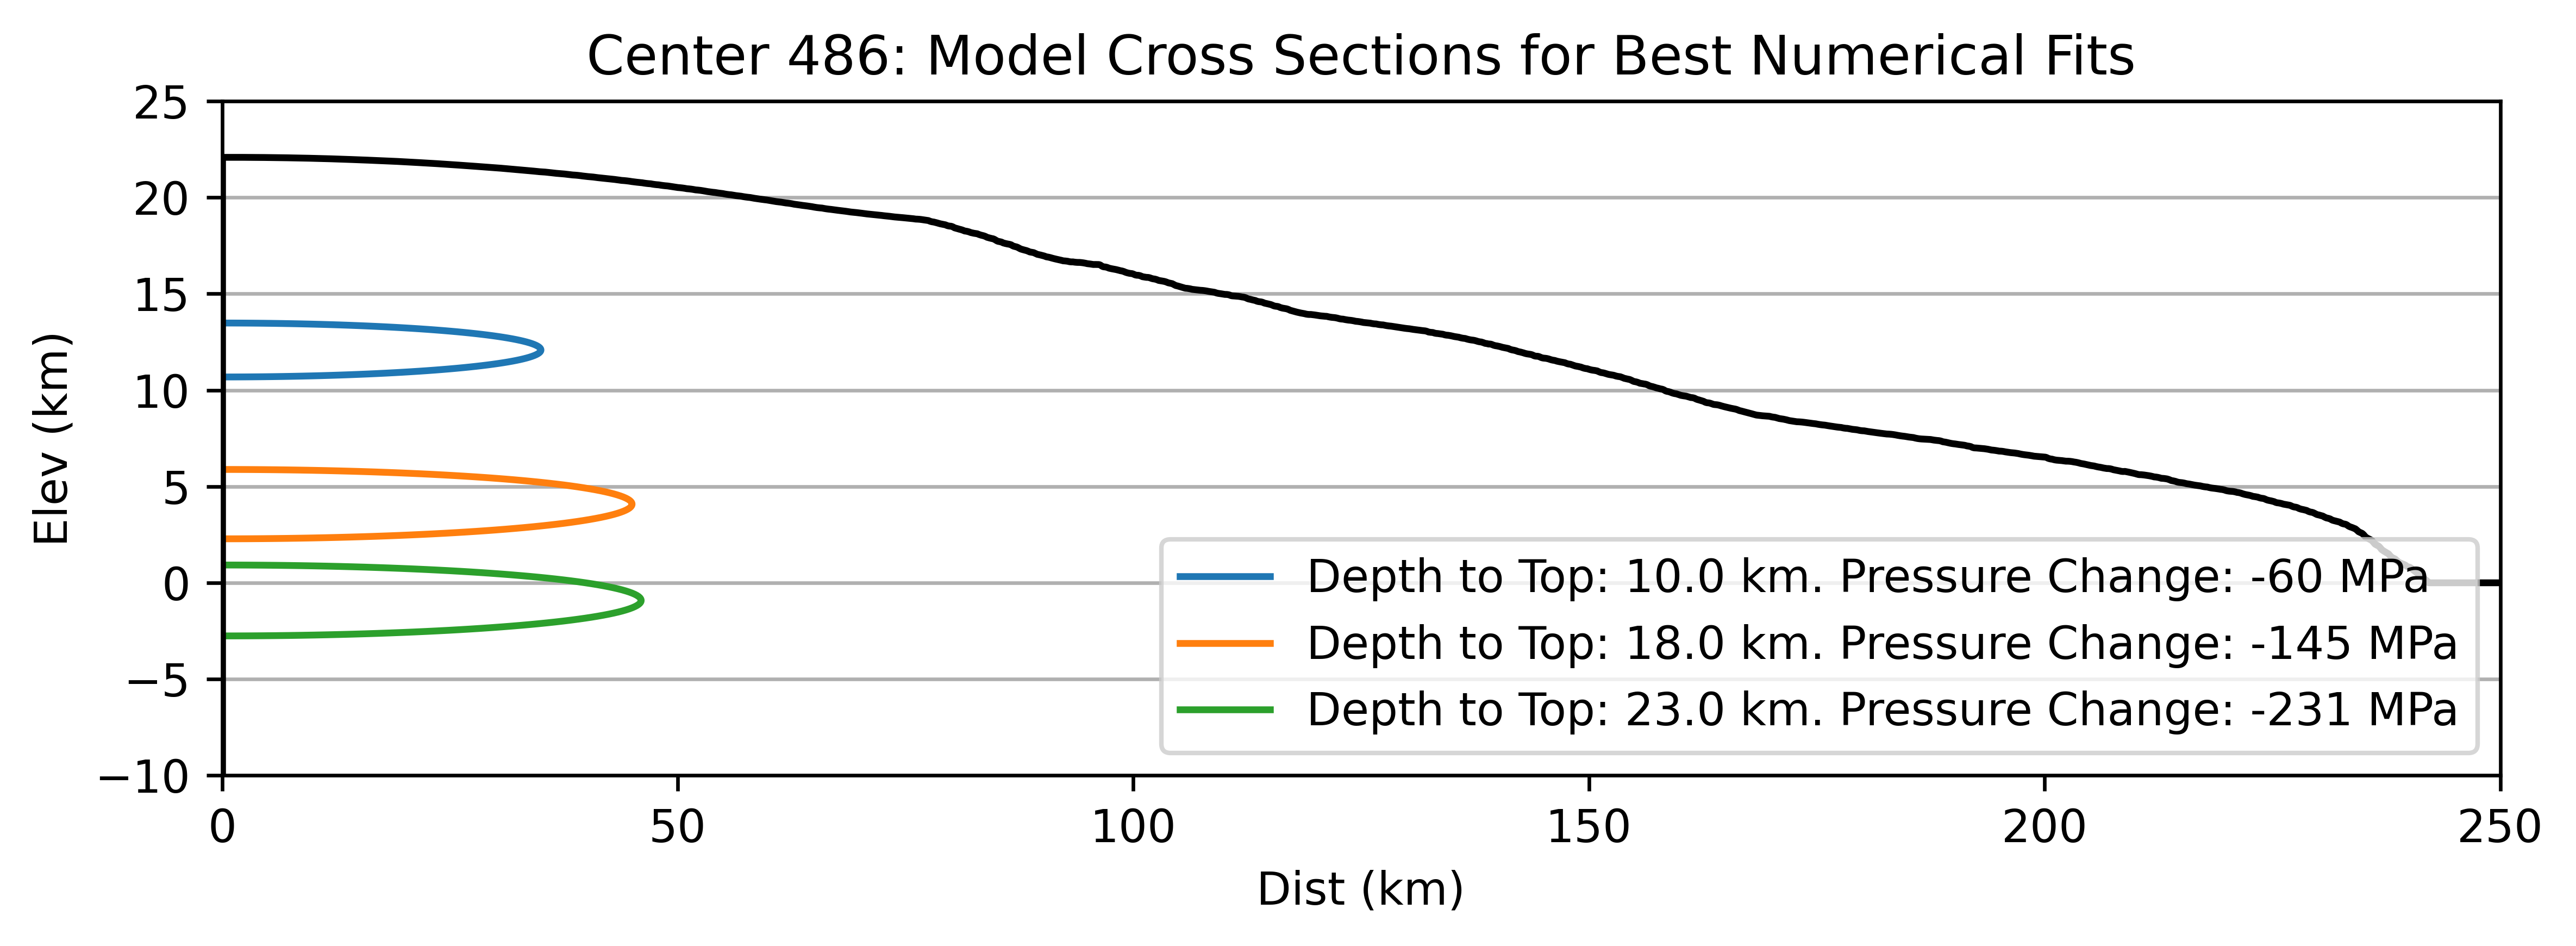

In [61]:
fig = plt.figure(figsize=(8,3), dpi=600)

for model in very_shallow_mid_width_sweep.models[:1]:
    model.plot_section(
        label=f'Depth to Top: {round(model.params["depth"]/1000,1)} km. Pressure Change: {round(model.over_pressure/1000_000)} MPa',
        max_elev_m=max(model_topo[1])
    )

for model in shallow_extra_wide_sweep.models[:1]:
    model.plot_section(
        label=f'Depth to Top: {round(model.params["depth"]/1000,1)} km. Pressure Change: {round(model.over_pressure/1000_000)} MPa',
        max_elev_m=max(model_topo[1])
    )

for model in deep_fine_tune_sweep.models[:1]:
    model.plot_section(
        label=f'Depth to Top: {round(model.params["depth"]/1000,1)} km. Pressure Change: {round(model.over_pressure/1000_000)} MPa',
        max_elev_m=max(model_topo[1])
    )

plt.legend()

plot_section()

plt.ylim(-10, 25)
plt.xlim(0, 250)

plt.grid(axis='y')
plt.legend(loc='lower right')

plt.title(f'Center {cID}: Model Cross Sections for Best Numerical Fits')

plt.xlabel('Dist (km)')
plt.ylabel('Elev (km)')

save_pdf(f'results/{cID}-cross-sections')